# New York City Airbnb Open Data
<br/>
<center>Francesco Di Salvo <br/> <i>Politecnico di Torino <br /> s282418@studenti.polito.it</i></center>
<br />


## Abstract
In this report we will explain my approach to the New York City Airbnb Dataset, where the aim is to predict the price of an apartement, based on fifteen parameters. In particular the current approach is based on a specific domain analysis, in which I discovered the parameters that most affect the price value. So, once the data were  cleaned, I was able to accomplish the regression task. The proposed approach outperforms a naive baseline for the same problem and it obtains overall satisfactory results. 

## I. Problem Overview
The current competition is a regression problem based on the New York City Airbnb Open Data, a collection of Airbnb listing in New York City, for the year 2019. The goal of the competition is to predict the price for each insertion  based on all the remaining features. The dadatset we have been given was divided into two part:
* developement set: a collection of "TOT "listings with the price column
* evaluation set: a collection of "TOT" listing without the price column 

Each row, contais the following attributes:
* id : it is an integer unique identifier of the ad
* name : it name of the ad
* host_id : it is an integer unique identifier of host that posted the current ad
* host name : it is the name of the host of the house
* neighbourhood_group : it is a categorical string that identifies the well-known area and we can distinguish five different groups: Brooklyn, Queens, Manharran, Bronx and Staten Island. By analyzing the listing distribution (see Figure 1) it is possible to see that they have an homogeneus density of listing, except for Staten Island that seems to have a bit less ads. 
* neighbourhood : it is another categorical string and identified a stricted location of the ad and we can distinguish "  " different ones
* latitude, longitude: they are the coordinates of the house. They are useful for identifying the distribution of the listing density on each neighborhood
* room_type : it is another categorical string, that identify the room's type and it can be "Private room", "Entire home/apt","Shared room". By analzing the distribution of those values it is possible to see that there are much less "Shared rooms" rather then the other ones (see Figure 2 and 3).
* price : it is contained just on the developement set and it is the price for the current listing, and this is also what we want to predict with our regression model.
* minimum nights : it is a booking constraint, because it refers to the minimum nights required for booking the home/apartement
* number_of_reviews : it is an integer that represents the number of reviews for the listing
* last_review : it is the date of the last_review and it is null for those apartement that have not any review yet.
* reviews_per_month : it specifies the number of reviews for the current month related to the apartement and it is strictly related to "last_review", because if there are no review (so it is null), reviews_per_month will be null too
* calculated_host_listings_count : it specifies the number of listing for the owner of that house
* availability_365 : this is an integer that repreents how many days the apartement is available for renting. It is possible to see that there are several (NUMBER) apartements with availability_365 equal to 0 and it may implies that the current listing actually "unavailable"

## II. Proposed approach

### A. Data preprocessing
First, I dropped the columns "name", "host_name", "last review". The first two columns should not affect the price of a listin, even tho for a quantitative answer, it would require a proper text mining analysis. Then, the last one is a date, so it is not easy to manage, but it is possible to make some consideration on its related attribute "reviews_per_month". 
<br /><br />
Then, a critical issues regards the categorical values, in particular we are talking about "neighbourhood", "neighbourhood_group" and "room_type". So, the first thing to do was to encode those categorical nominal into integer values. I used the factorize() method provided by pandas that converts all the distinct strings into distinct values. In order to have a perfect correspondance among the evaluation set and the test set, I used the factorize method on the concatenation of both datasets. I was able to distinguish then the different datasets because the evaluation set had null values on the price label. 
<br /><br />

Finally, I was able to look for the correlation for the price. Since a negative correlation is useful too, I considered the abs of the correlation matrix. I decided to drop the last three columns that were : 'id','neighborhood' and 'host_id'. As we may imagine, the value that mostly affects the price is 'room_type'. You can see the complete list on the Table 1. 

### B. Model selection

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
dev_df = pd.read_csv('../Datasets/NYC_Airbnb/development.csv')
eval_df = pd.read_csv('../Datasets/NYC_Airbnb/evaluation.csv')
labels = eval_df['id']

In [41]:
dev_df.shape, eval_df.shape

((39116, 16), (9779, 15))

## EDA

In [43]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39116 entries, 0 to 39115
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39116 non-null  int64  
 1   host_id                         39116 non-null  int64  
 2   neighbourhood_group             39116 non-null  object 
 3   neighbourhood                   39116 non-null  object 
 4   latitude                        39116 non-null  float64
 5   longitude                       39116 non-null  float64
 6   room_type                       39116 non-null  object 
 7   price                           39116 non-null  int64  
 8   minimum_nights                  39116 non-null  int64  
 9   number_of_reviews               39116 non-null  int64  
 10  reviews_per_month               39116 non-null  float64
 11  calculated_host_listings_count  39116 non-null  int64  
 12  availability_365                

In [6]:
dev_df.isnull().sum()

id                                   0
name                                13
host_id                              0
host_name                           19
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8041
reviews_per_month                 8041
calculated_host_listings_count       0
availability_365                     0
dtype: int64

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

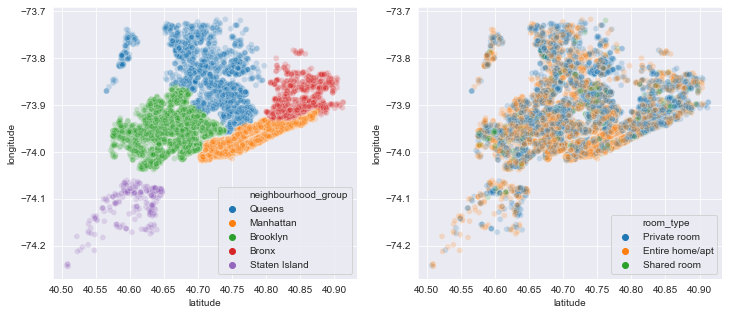

In [4]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(dev_df['latitude'], dev_df['longitude'], alpha=0.2,ax=axes[0], hue=dev_df.neighbourhood_group)
sns.scatterplot(dev_df['latitude'], dev_df['longitude'], alpha=0.2,ax=axes[1], hue=dev_df.room_type)

<AxesSubplot:xlabel='room_type', ylabel='count'>

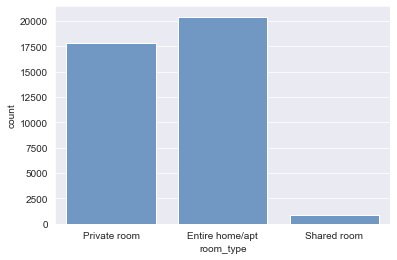

In [9]:
sns.countplot(x="room_type", data=dev_df, color="#6397d0")

## Data preprocessing

In [50]:
def clean(df):
    # eliminate unuseful attributes 
    df = df.drop(columns=["name","host_name","last_review"])

    # null values on review_per_month : fill with the average
    df['reviews_per_month'].fillna(0, inplace=True)
        
    return df

def encode_categories(dev, ev, columns):
    for column in columns:

        # concat both dataframes in order to have the same encoding
        # the ones with NaN belong the ev_set
        
        df = pd.concat([dev,ev])
        df[column] = df[column].factorize()[0]
        
        ev = df[df['price'].isna()].drop(columns=['price'])
        dev = df.dropna(subset=['price'])
        
    return dev, ev
    

In [51]:
columns_to_encode = ['neighbourhood_group', 'room_type','neighbourhood']
columns_to_normalize = ['calculated_host_listings_count','number_of_reviews','minimum_nights']

dev_df = clean(dev_df)
eval_df = clean(eval_df)

dev_df = normalize(dev_df,columns_to_normalize)

dev_df_enc, eval_df_enc = encode_categories(dev_df.copy(),eval_df.copy(),columns_to_encode)

In [52]:
abs(dev_df_enc.corr()['price']).sort_values(ascending=False)

price                             1.000000
room_type                         0.204980
longitude                         0.148891
availability_365                  0.082667
calculated_host_listings_count    0.055070
reviews_per_month                 0.053285
neighbourhood_group               0.049987
number_of_reviews                 0.048254
minimum_nights                    0.044238
latitude                          0.031274
host_id                           0.015168
neighbourhood                     0.013436
id                                0.009273
Name: price, dtype: float64

## Model selection

In [54]:
y_dev = dev_df_enc.price
X_dev = dev_df_enc.drop(columns=['price','host_id','neighbourhood','id'])
X_eval = eval_df_enc.drop(columns=['host_id','neighbourhood','id'])

In [ ]:
## LINEAR REGRESSION ##
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def doLinearReg(in_X,in_y):
    
    model = LinearRegression()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='r2',
                         cv=5,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.
    gs.fit(in_X, in_y)
    best_parameters_LR = gs.best_params_  
    best_score_LR = gs.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)

doLinearReg(X_dev,y_dev)

In [ ]:
## RANDOM FOREST ##
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def doRandomForest(in_X,in_y):
    
    model = RandomForestRegressor(n_jobs=-1)
    parameters = {
        'n_estimators':[400,600,700], 
        'max_depth':[400,500]
    }
    
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='r2',
                         cv=4,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.
    gs.fit(in_X, in_y)
    best_parameters = gs.best_params_  
    best_score = gs.best_score_ 
    print(best_parameters)
    print(best_score)
    
## doRandomForest(X_dev,y_dev)

In [ ]:
## TRAIN ON RANDOM FOREST ì
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X_dev,y_dev,test_size=0.2,random_state=105)

rf = RandomForestRegressor(max_depth=400, n_estimators=700)
rf.fit(X_train, y_train)
rf_pred = rf4.predict(X_test)

print(r2_score(y_test2,rf_pred))

## Evaluation

In [ ]:
rf_final = RandomForestRegressor(max_depth=400, n_estimators=700)
rf_final.fit(X_dev, y_dev)

In [ ]:
rf_pred_final = rf_final.predict(X_eval)

In [ ]:
pd.DataFrame( dict(Id = eval_df['id'],
                   Predicted = rf_pred_final)
            ).to_csv("submissionL9_V7.csv",sep=",",index=False)